In [1]:
!pip install attention

In [2]:
from google.colab import files

uploaded = files.upload()

Saving clean_tweet_char.csv to clean_tweet_char.csv
Saving data_helpers.py to data_helpers.py
Saving en.wiki.bpe.op25000.d50.w2v.bin to en.wiki.bpe.op25000.d50.w2v.bin
Saving en.wiki.bpe.op25000.vocab to en.wiki.bpe.op25000.vocab


In [4]:
import os
import pandas as pd
import numpy as np
import data_helpers
import pickle
import matplotlib.pyplot as plt


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPooling1D, Flatten
from keras.layers import Activation, MaxPooling1D, BatchNormalization, GRU, Bidirectional, SpatialDropout1D, Concatenate
from attention import Attention

from sklearn.metrics import accuracy_score
from sklearn.metrics import  classification_report

from data_helpers import BPE

In [7]:
# Load data
csv = '/content/clean_tweet_char.csv'
df_train = pd.read_csv(csv, index_col=0)
print(df_train.head())

# Delete Null row
df_train = df_train.dropna()

x_text = df_train['tweet'].values

                                               tweet
0                i`d have responded, if i were going
1      sooo sad i will miss you here in san diego!!!
2                          my boss is bullying me...
3                     what interview! leave me alone
4  sons of ****, why couldn`t they put them on th...


In [8]:
labels = np.ones((len(df_train), 1))
random_raw_df = pd.read_csv('/content/Detecting-Depression-Through-Tweets/random_tweets.csv')

for i in range(len(random_raw_df)):
    labels[i] = 0

labels = to_categorical(labels)

In [9]:
# Convert subword to index, function version
def subword2index(texts, vocab):
    
    sentences = []
    for s in texts:
    
        s = s.split()
        one_line = []
        
        for word in s:
            
            if word not in vocab.keys():
                one_line.append(vocab['unk'])
            else:
                one_line.append(vocab[word])
        
        sentences.append(one_line)
    
    return sentences


# replace all digits with 0
import re

train_texts = [re.sub('\d', '0', s) for s in x_text]

# replace all URLs with <url>
url_reg = r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b'
train_texts = [re.sub(url_reg, '<url>', s) for s in train_texts]

# Convert string to subword, this process may take several minutes
bpe = BPE("/content/en.wiki.bpe.op25000.vocab")
train_texts = [bpe.encode(s) for s in train_texts]

# Build vocab, {token: index}
vocab = {}
for i, token in enumerate(bpe.words):
    vocab[token] = i + 1

# Convert train and test
train_sentences = subword2index(train_texts, vocab)

In [10]:
# See subword level length
length = [len(sent) for sent in train_sentences]
print('The max length is: ', max(length))
print('The min length is: ', min(length))
print('The average length is: ', sum(length)/len(length))

The max length is:  252
The min length is:  1
The average length is:  30.240522595844936


In [11]:
# Padding
train_data = pad_sequences(train_sentences, maxlen=252, padding='post')

# Shuffle data
np.random.seed(42)
shuffle_indices = np.random.permutation(np.arange(len(labels)))
x_shuffled = train_data[shuffle_indices]
labels_shuffled = labels[shuffle_indices]

# Split train and test
training_rate = 0.9
train_len = int(len(labels) * training_rate)
x_train = x_shuffled[:train_len]
labels_train = labels_shuffled[:train_len]
x_test = x_shuffled[train_len:]
labels_test = labels_shuffled[train_len:]

print('Training data size is: ', x_train.shape)
print('Validation data size is: ', x_test.shape)

Training data size is:  (8404, 252)
Validation data size is:  (934, 252)


In [12]:
# Embedding Initialization
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("/content/en.wiki.bpe.op25000.d50.w2v.bin", binary=True)

In [13]:
from keras.layers import Embedding

input_size = 252
embedding_dim = 50
embedding_weights = np.zeros((len(vocab) + 1, embedding_dim)) 

In [14]:
for subword, i in vocab.items():
    
    if subword in model.vocab:
        
        embedding_vector = model[subword]
        if embedding_vector is not None:
            embedding_weights[i] = embedding_vector
    
    else:
        continue

embedding_layer = Embedding(len(vocab)+1,
                            embedding_dim,
                            weights=[embedding_weights],
                            input_length=input_size,
                            trainable=False)

### Baseline (Logistic Regression)

In [58]:
from sklearn.linear_model import LogisticRegression

class_labels_train = np.argmax(labels_train, axis=1)
class_labels_test = np.argmax(labels_test, axis=1)

logreg = LogisticRegression(max_iter = 5000)
logreg.fit(x_train, class_labels_train)
accuracy = logreg.score(x_test, class_labels_test)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 87.47%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### CNN

In [15]:
cnn_model = Sequential()

cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(2, activation='sigmoid'))

In [16]:
cnn_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 252, 50)           1250050   
_________________________________________________________________
conv1d (Conv1D)              (None, 252, 128)          32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 1,283,490
Trainable params: 33,440
Non-trainable params: 1,250,050
_________________________________________

In [17]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

hist = cnn_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
211/211 [==============================] - 1s 6ms/step - loss: 0.2327 - acc: 0.9167 - val_loss: 0.0757 - val_acc: 0.9810
Epoch 2/30
211/211 [==============================] - 1s 6ms/step - loss: 0.0708 - acc: 0.9807 - val_loss: 0.0621 - val_acc: 0.9839
Epoch 3/30
211/211 [==============================] - 1s 6ms/step - loss: 0.0536 - acc: 0.9851 - val_loss: 0.0502 - val_acc: 0.9869
Epoch 4/30
211/211 [==============================] - 1s 5ms/step - loss: 0.0438 - acc: 0.9874 - val_loss: 0.0469 - val_acc: 0.9887
Epoch 5/30
211/211 [==============================] - 1s 5ms/step - loss: 0.0353 - acc: 0.9900 - val_loss: 0.0471 - val_acc: 0.9881
Epoch 6/30
211/211 [==============================] - 1s 5ms/step - loss: 0.0241 - acc: 0.9930 - val_loss: 0.0409 - val_acc: 0.9893
Epoch 7/30
211/211 [==============================] - 1s 5ms/step - loss: 0.0256 - acc: 0.9927 - val_loss: 0.0425 - val_acc: 0.9905
Epoch 8/30
211/211 [==============================] - 1s 5ms/step - loss: 0.

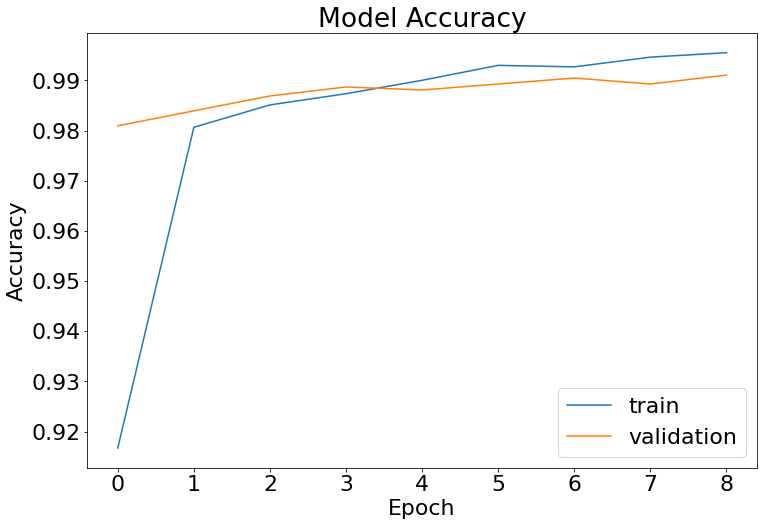

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

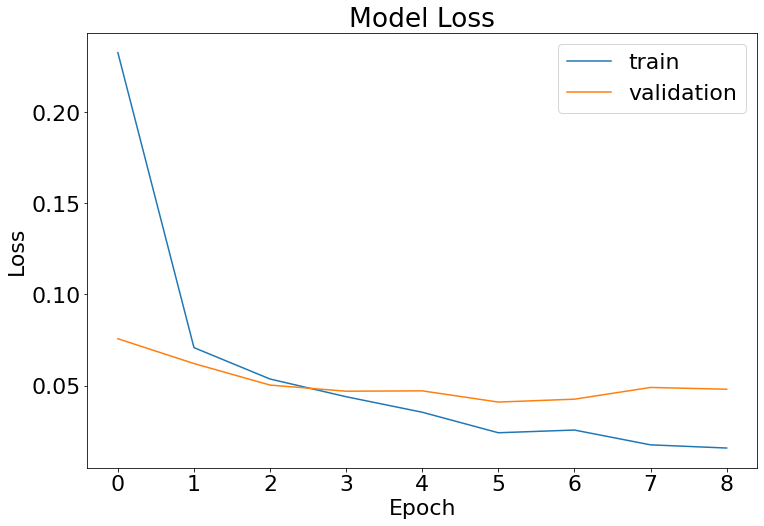

In [19]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [20]:
labels_pred = cnn_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.46%


In [21]:
print(classification_report(labels_test, labels_pred))
cnn_model.save('Detecting-Depression-Through-Tweets/cnn-sub.h5')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       818
           1       0.99      0.97      0.98       116

   micro avg       0.99      0.99      0.99       934
   macro avg       0.99      0.98      0.99       934
weighted avg       0.99      0.99      0.99       934
 samples avg       0.99      0.99      0.99       934



# LSTM

In [22]:
lstm_model = Sequential()

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(300))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(2, activation='sigmoid'))

In [23]:
lstm_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 252, 50)           1250050   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               421200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 602       
Total params: 1,671,852
Trainable params: 421,802
Non-trainable params: 1,250,050
_________________________________________________________________
None


In [24]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#hist = model_lstm.fit(x_train, labels_train, batch_size=batch_size, epochs=40, callbacks=[earlystopper], validation_split=0.1, shuffle=True, verbose=1)
hist = lstm_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
211/211 [==============================] - 5s 23ms/step - loss: 0.4185 - acc: 0.8577 - val_loss: 0.4232 - val_acc: 0.8554
Epoch 2/30
211/211 [==============================] - 4s 21ms/step - loss: 0.4196 - acc: 0.8574 - val_loss: 0.4645 - val_acc: 0.8554
Epoch 3/30
211/211 [==============================] - 4s 21ms/step - loss: 0.4122 - acc: 0.8605 - val_loss: 0.4156 - val_acc: 0.8554
Epoch 4/30
211/211 [==============================] - 4s 21ms/step - loss: 0.4065 - acc: 0.8605 - val_loss: 0.4163 - val_acc: 0.8554
Epoch 5/30
211/211 [==============================] - 5s 22ms/step - loss: 0.4071 - acc: 0.8605 - val_loss: 0.4152 - val_acc: 0.8554
Epoch 6/30
211/211 [==============================] - 4s 21ms/step - loss: 0.4080 - acc: 0.8606 - val_loss: 0.4141 - val_acc: 0.8554
Epoch 7/30
211/211 [==============================] - 4s 21ms/step - loss: 0.4071 - acc: 0.8605 - val_loss: 0.4163 - val_acc: 0.8554
Epoch 8/30
211/211 [==============================] - 4s 21ms/step - 

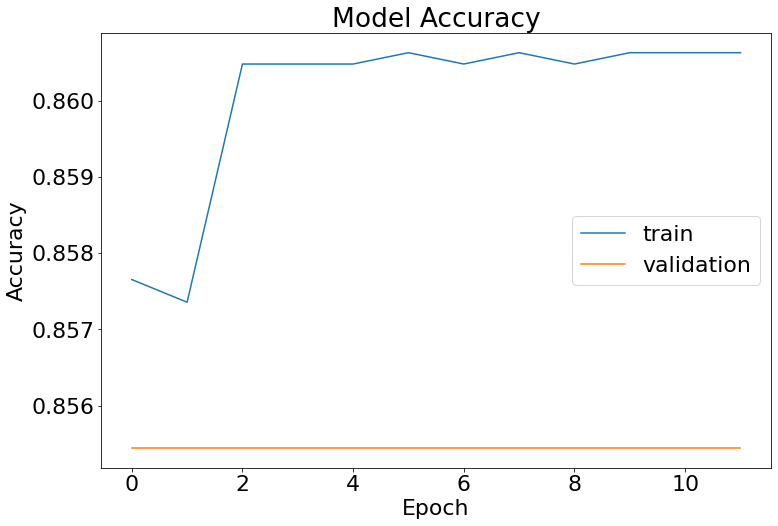

In [25]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

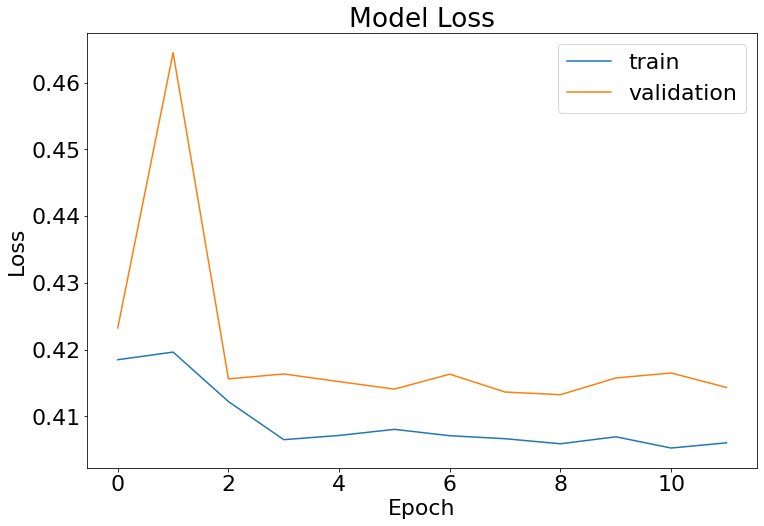

In [26]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [27]:
labels_pred = lstm_model.predict(x_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 87.58%


In [28]:
print(classification_report(labels_test, labels_pred, average='weighted', labels=np.unique(labels_pred)))
lstm_model.save('Detecting-Depression-Through-Tweets/lstm-sub.h5')

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       818
           1       0.00      0.00      0.00       116

   micro avg       0.88      0.88      0.88       934
   macro avg       0.44      0.50      0.47       934
weighted avg       0.77      0.88      0.82       934
 samples avg       0.88      0.88      0.88       934



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LSTM + CNN

In [29]:
lstm_cnn_model = Sequential()

lstm_cnn_model.add(embedding_layer)
lstm_cnn_model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
lstm_cnn_model.add(MaxPooling1D(pool_size=2))
lstm_cnn_model.add(Dropout(0.2))
lstm_cnn_model.add(LSTM(300))
lstm_cnn_model.add(Dropout(0.2))
lstm_cnn_model.add(Dense(2, activation='sigmoid'))

In [30]:
lstm_cnn_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(lstm_cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 252, 50)           1250050   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 252, 64)           6464      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 126, 64)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 126, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               438000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [31]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#hist = model_lstm.fit(x_train, labels_train, batch_size=batch_size, epochs=40, callbacks=[earlystopper], validation_split=0.1, shuffle=True, verbose=1)
hist = lstm_cnn_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
211/211 [==============================] - 3s 16ms/step - loss: 0.4188 - acc: 0.8596 - val_loss: 0.4197 - val_acc: 0.8554
Epoch 2/30
211/211 [==============================] - 3s 13ms/step - loss: 0.4071 - acc: 0.8605 - val_loss: 0.4175 - val_acc: 0.8554
Epoch 3/30
211/211 [==============================] - 3s 13ms/step - loss: 0.4057 - acc: 0.8605 - val_loss: 0.4169 - val_acc: 0.8554
Epoch 4/30
211/211 [==============================] - 3s 13ms/step - loss: 0.4268 - acc: 0.8556 - val_loss: 0.4166 - val_acc: 0.8554
Epoch 5/30
211/211 [==============================] - 3s 13ms/step - loss: 0.4080 - acc: 0.8605 - val_loss: 0.4216 - val_acc: 0.8554
Epoch 6/30
211/211 [==============================] - 3s 13ms/step - loss: 0.4079 - acc: 0.8606 - val_loss: 0.4185 - val_acc: 0.8554
Epoch 7/30
211/211 [==============================] - 3s 13ms/step - loss: 0.4061 - acc: 0.8606 - val_loss: 0.4138 - val_acc: 0.8554
Epoch 8/30
211/211 [==============================] - 3s 13ms/step - 

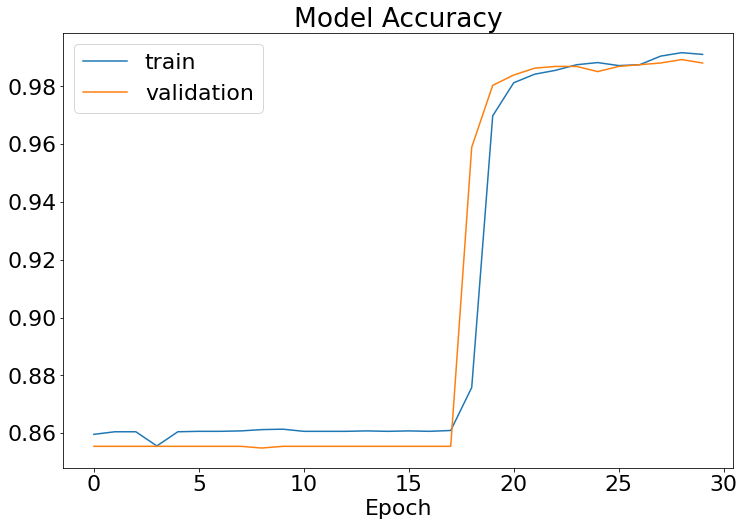

In [32]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

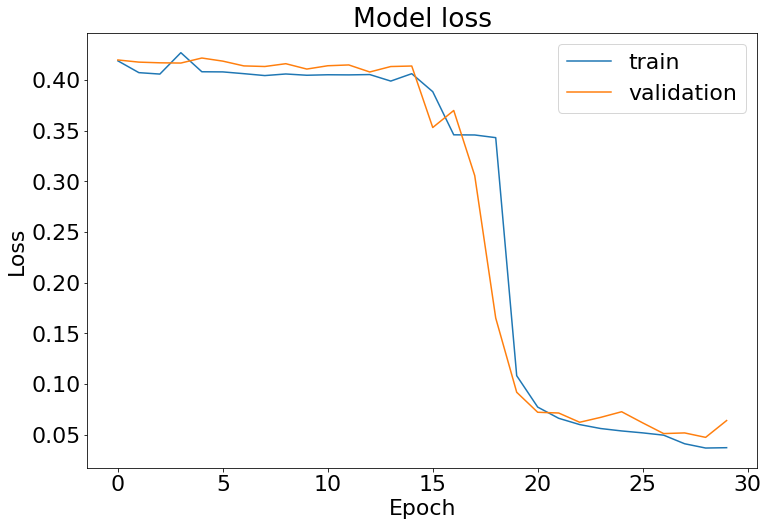

In [33]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [34]:
labels_pred = lstm_cnn_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.46%


In [35]:
print(classification_report(labels_test, labels_pred))
lstm_cnn_model.save('Detecting-Depression-Through-Tweets/lstm-cnn-char.h5')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       818
           1       1.00      0.96      0.98       116

   micro avg       0.99      0.99      0.99       934
   macro avg       1.00      0.98      0.99       934
weighted avg       0.99      0.99      0.99       934
 samples avg       0.99      0.99      0.99       934



### BiLSTM

In [36]:
bilstm_model = Sequential()

bilstm_model.add(embedding_layer)
bilstm_model.add(Bidirectional(LSTM(300)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(2, activation='sigmoid'))

In [37]:
bilstm_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(bilstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 252, 50)           1250050   
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               842400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1202      
Total params: 2,093,652
Trainable params: 843,602
Non-trainable params: 1,250,050
_________________________________________________________________
None


In [38]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#hist = model_lstm.fit(x_train, labels_train, batch_size=batch_size, epochs=40, callbacks=[earlystopper], validation_split=0.1, shuffle=True, verbose=1)
hist = bilstm_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
211/211 [==============================] - 9s 45ms/step - loss: 0.2396 - acc: 0.9143 - val_loss: 0.1055 - val_acc: 0.9673
Epoch 2/30
211/211 [==============================] - 9s 42ms/step - loss: 0.0889 - acc: 0.9740 - val_loss: 0.1335 - val_acc: 0.9655
Epoch 3/30
211/211 [==============================] - 9s 42ms/step - loss: 0.0750 - acc: 0.9796 - val_loss: 0.0680 - val_acc: 0.9851
Epoch 4/30
211/211 [==============================] - 9s 42ms/step - loss: 0.0581 - acc: 0.9862 - val_loss: 0.0645 - val_acc: 0.9851
Epoch 5/30
211/211 [==============================] - 9s 42ms/step - loss: 0.1889 - acc: 0.9447 - val_loss: 0.4186 - val_acc: 0.8554
Epoch 6/30
211/211 [==============================] - 9s 41ms/step - loss: 0.3689 - acc: 0.8660 - val_loss: 0.1793 - val_acc: 0.9334
Epoch 7/30
211/211 [==============================] - 9s 42ms/step - loss: 0.2337 - acc: 0.9106 - val_loss: 0.2115 - val_acc: 0.9340
Epoch 00007: early stopping


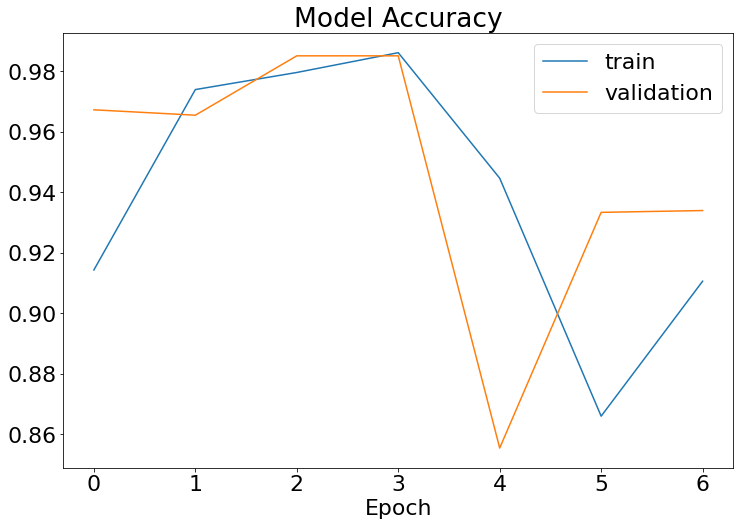

In [39]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

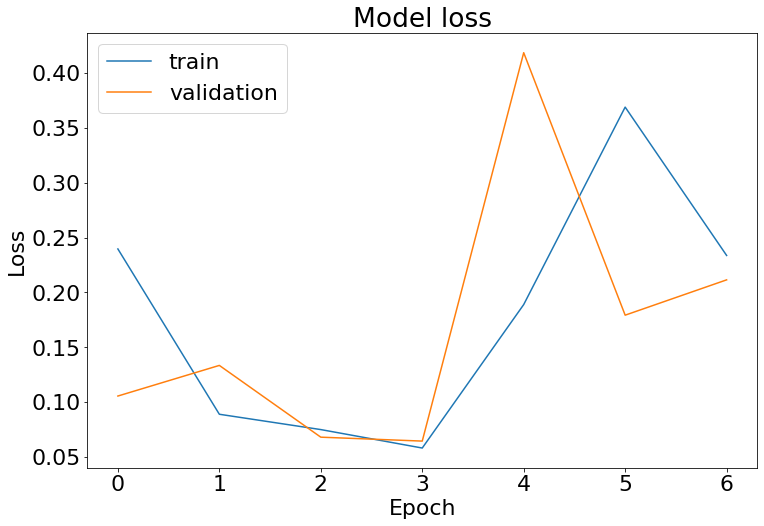

In [40]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [41]:
labels_pred = bilstm_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 94.97%


In [42]:
print(classification_report(labels_test, labels_pred))
bilstm_model.save('Detecting-Depression-Through-Tweets/bilstm-char.h5')

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       818
           1       0.82      0.76      0.79       116

   micro avg       0.95      0.95      0.95       934
   macro avg       0.89      0.87      0.88       934
weighted avg       0.95      0.95      0.95       934
 samples avg       0.95      0.95      0.95       934



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### GRU

In [43]:
gru_model = Sequential()

gru_model.add(embedding_layer)
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(Bidirectional(GRU(300)))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(2, activation='sigmoid'))

In [44]:
gru_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(gru_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 252, 50)           1250050   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 252, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               633600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1202      
Total params: 1,884,852
Trainable params: 634,802
Non-trainable params: 1,250,050
_________________________________________________________________
None


In [45]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#hist = model_lstm.fit(x_train, labels_train, batch_size=batch_size, epochs=40, callbacks=[earlystopper], validation_split=0.1, shuffle=True, verbose=1)
hist = gru_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
211/211 [==============================] - 8s 40ms/step - loss: 0.1790 - acc: 0.9417 - val_loss: 0.0910 - val_acc: 0.9774
Epoch 2/30
211/211 [==============================] - 8s 37ms/step - loss: 0.1034 - acc: 0.9717 - val_loss: 0.0887 - val_acc: 0.9774
Epoch 3/30
211/211 [==============================] - 8s 37ms/step - loss: 0.0825 - acc: 0.9795 - val_loss: 0.0698 - val_acc: 0.9851
Epoch 4/30
211/211 [==============================] - 8s 37ms/step - loss: 0.0703 - acc: 0.9830 - val_loss: 0.0662 - val_acc: 0.9875
Epoch 5/30
211/211 [==============================] - 8s 37ms/step - loss: 0.0746 - acc: 0.9792 - val_loss: 0.0643 - val_acc: 0.9881
Epoch 6/30
211/211 [==============================] - 8s 37ms/step - loss: 0.0585 - acc: 0.9841 - val_loss: 0.0562 - val_acc: 0.9893
Epoch 7/30
211/211 [==============================] - 8s 37ms/step - loss: 0.0551 - acc: 0.9874 - val_loss: 0.0581 - val_acc: 0.9887
Epoch 8/30
211/211 [==============================] - 8s 36ms/step - 

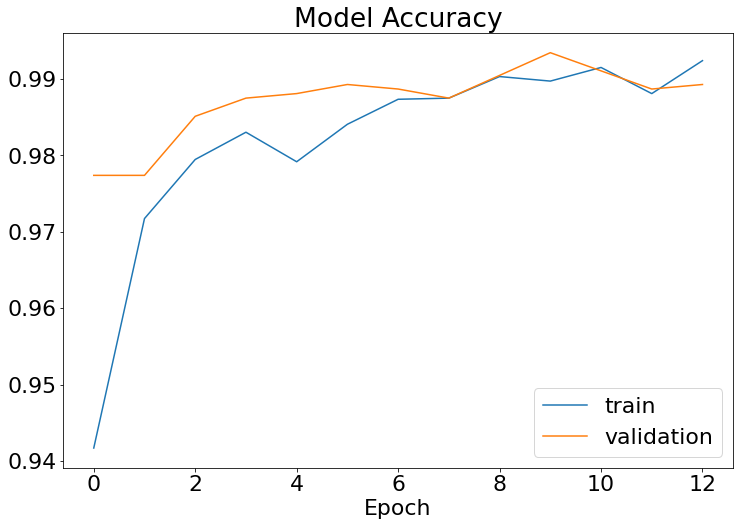

In [46]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

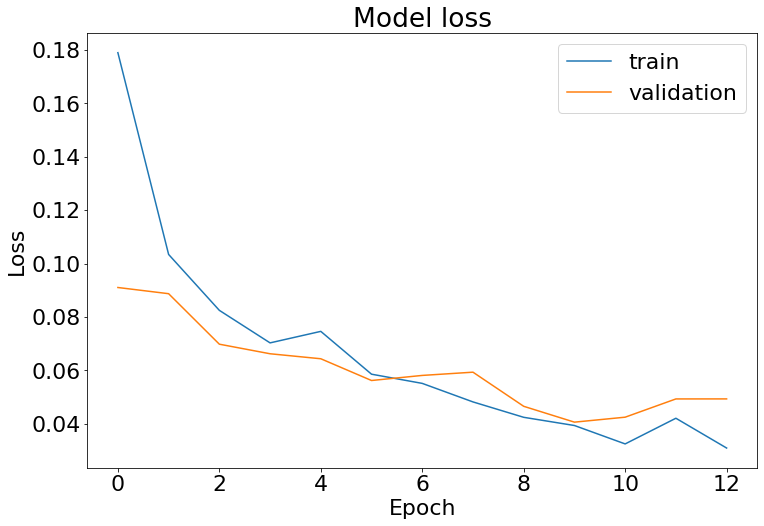

In [47]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [48]:
labels_pred = gru_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.25%


In [49]:
print(classification_report(labels_test, labels_pred))
gru_model.save('Detecting-Depression-Through-Tweets/gru-char.h5')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       818
           1       0.99      0.95      0.97       116

   micro avg       0.99      0.99      0.99       934
   macro avg       0.99      0.97      0.98       934
weighted avg       0.99      0.99      0.99       934
 samples avg       0.99      0.99      0.99       934



### Attention-Based BiLSTM+CNN Model

In [50]:
attention_model = Sequential()
attention_model.add(embedding_layer)
attention_model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
attention_model.add(MaxPooling1D(pool_size=2))
attention_model.add(Dropout(0.6))
attention_model.add(Bidirectional(LSTM(300, return_sequences=True)))
attention_model.add(Attention())
attention_model.add(Dense(2, activation='sigmoid'))

In [51]:
attention_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(attention_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 252, 50)           1250050   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 252, 64)           6464      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 126, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 126, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 126, 600)          876000    
_________________________________________________________________
attention_score_vec (Dense)  (None, 126, 600)          360000    
_________________________________________________________________
last_hidden_state (Lambda)   (None, 600)              

In [52]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#hist = model_lstm.fit(x_train, labels_train, batch_size=batch_size, epochs=40, callbacks=[earlystopper], validation_split=0.1, shuffle=True, verbose=1)
hist = attention_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
211/211 [==============================] - 7s 32ms/step - loss: 0.2425 - acc: 0.9169 - val_loss: 0.0802 - val_acc: 0.9744
Epoch 2/30
211/211 [==============================] - 6s 29ms/step - loss: 0.0953 - acc: 0.9723 - val_loss: 0.0689 - val_acc: 0.9822
Epoch 3/30
211/211 [==============================] - 6s 29ms/step - loss: 0.1179 - acc: 0.9636 - val_loss: 2.5182 - val_acc: 0.1446
Epoch 4/30
211/211 [==============================] - 6s 28ms/step - loss: 0.1159 - acc: 0.9624 - val_loss: 0.5192 - val_acc: 0.7936
Epoch 5/30
211/211 [==============================] - 6s 29ms/step - loss: 0.0784 - acc: 0.9759 - val_loss: 0.0564 - val_acc: 0.9851
Epoch 6/30
211/211 [==============================] - 6s 29ms/step - loss: 0.0583 - acc: 0.9833 - val_loss: 0.0525 - val_acc: 0.9881
Epoch 7/30
211/211 [==============================] - 6s 29ms/step - loss: 0.0532 - acc: 0.9851 - val_loss: 0.0550 - val_acc: 0.9869
Epoch 8/30
211/211 [==============================] - 6s 29ms/step - 

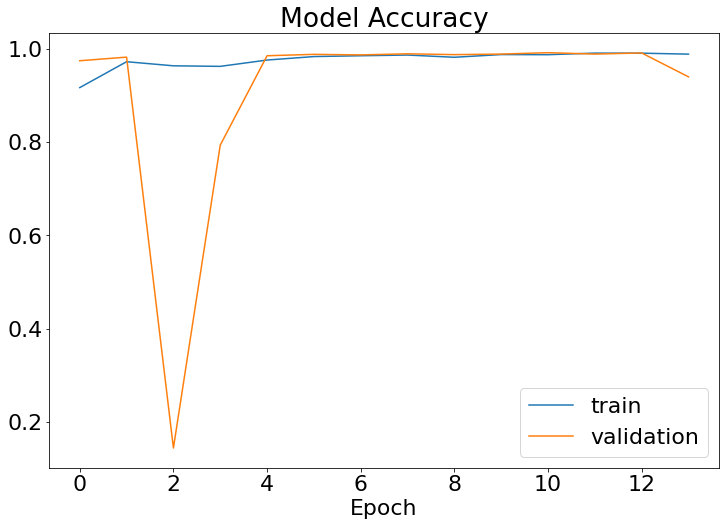

In [53]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

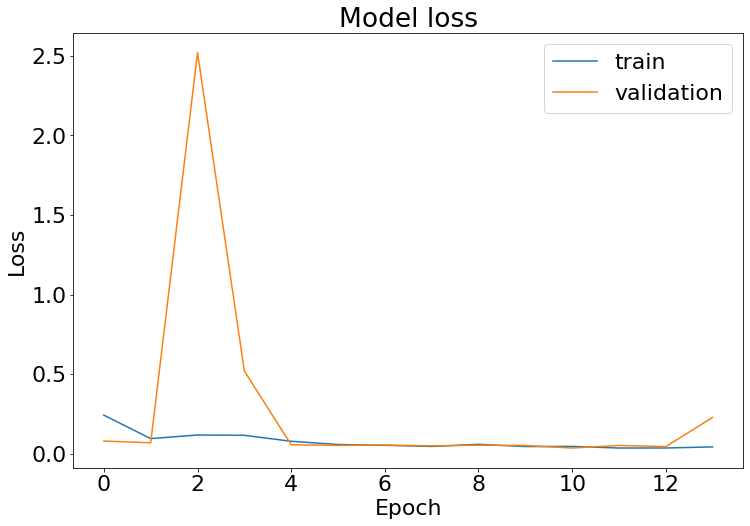

In [54]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [55]:
labels_pred = attention_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 91.01%


In [56]:
print(classification_report(labels_test, labels_pred))
attention_model.save('Detecting-Depression-Through-Tweets/attention-char.h5')

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       818
           1       0.59      0.97      0.73       116

   micro avg       0.91      0.96      0.93       934
   macro avg       0.79      0.96      0.85       934
weighted avg       0.94      0.96      0.94       934
 samples avg       0.93      0.96      0.94       934

